In [ ]:
#### IMPORTS  ####
from pathlib import Path
from typing import Tuple, List
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
import random
import datetime
import pathlib
import pytz
import glob
import re
from google.colab import drive
from torch.autograd import Variable
import seaborn as sns
import matplotlib.dates as mdates
drive.mount('/content/drive', force_remount=True)

In [ ]:
#### Definitions ####
PATH_ROOT = "drive/MyDrive/Efrat/" # Change only here the path
PATH_DATA  = PATH_ROOT + "Data/IMD_areal_Godavari/"
PATH_LABEL = PATH_ROOT + "Data/CWC/"
PATH_MODEL = PATH_ROOT + "shared_lstm/"
PREC_FORMAT = "Area_avg_precipitation_IMD_{0}_updated"
DATA_FORMAT = "Area_avg_tmax_tmin_wind_{0}_updated"
DISCH_FORMAT = "CWC_discharge_{0}_clean"
STAGE_FORMAT = "CWC_stage_{0}_new"
PATH_CATCHMENTS = PATH_ROOT + "Data/catchments.xlsx" 

def get_basin_raw_data(basin_name, start_date, end_date):
   
  # Getting precipitation 
  data_precipitation = pd.read_csv(PATH_DATA + PREC_FORMAT.format(basin_name), header=None, delim_whitespace=True)
  idx_start, idx_end  = get_index(data_precipitation, start_date) , get_index(data_precipitation, end_date) 
  x = np.array(data_precipitation[3][idx_start:idx_end+1])

  # Getting  Tmax, Tmin
  data_added = pd.read_csv(PATH_DATA + DATA_FORMAT.format(basin_name), header=None, delim_whitespace=True)
  idx_start, idx_end = get_index(data_added, start_date), get_index(data_added, end_date)
  x = np.concatenate([[x], [np.array(data_added[3][idx_start:idx_end+1])], [np.array(data_added[4][idx_start:idx_end+1])]]).T

  # Getting Discharge
  data_discharge = pd.read_csv(PATH_LABEL + DISCH_FORMAT.format(basin_name), header=None, delim_whitespace=True)
  idx_start, idx_end = get_index(data_discharge, start_date), get_index(data_discharge, end_date)
  y = np.array(data_discharge[3][idx_start:idx_end+1])

  # Getting Stage 
  data_stage = pd.read_csv(PATH_LABEL + STAGE_FORMAT.format(basin_name), header=None, delim_whitespace=True)
  idx_start, idx_end = get_index(data_stage, start_date), get_index(data_stage, end_date)
  stage = np.array(data_stage[3][idx_start:idx_end+1])
  # TODO clean all NAN by interpulation - NOT YET DONE 
  
  # x.shape (num_sample, num_features)
  # num_features- 0: precipitation, 1: Tmax, 2: Tmin
  return x, y, stage

def get_index(data, date_input):
  year, month, day= date_input
  return int(np.where(np.array(data[0] == year)*np.array(data[1] == month)*np.array(data[2] == day))[0].squeeze())

def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Reshape matrix data into sample shape for LSTM training.
  :param x: Matrix containing input features column wise and time steps row wise
  :param y: Matrix containing the output feature.
  :param seq_length: Length of look back days for one day of prediction 
  :return: Two np.ndarrays, the first of shape (samples, length of sequence,
    number of features), containing the input data for the LSTM. The second
    of shape (samples, 1) containing the expected output for each input
    sample.
  """
  num_samples, num_features = x.shape
  x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
  y_new = np.zeros((num_samples - seq_length + 1, 1))
  for i in range(0, x_new.shape[0]):
    x_new[i, :, :num_features] = x[i:i + seq_length, :]
    y_new[i, :] = y[i + seq_length - 1, 0]
  return x_new, y_new

def reshape_data_basins(x: np.ndarray, y: np.ndarray, seq_length: int, basin_list: list, lead: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Reshape matrix data into sample shape for LSTM training.
  :param x: Matrix containing input features column wise and time steps row wise
  :param y: Matrix containing the output feature.
  :param seq_length: Length of look back days for one day of prediction 
  :param seq_length: Length of look back days for one day of prediction
  :return: Two np.ndarrays, the first of shape (samples, length of sequence,
    number of features), containing the input data for the LSTM. The second
    of shape (samples, 1) containing the expected output for each input
    sample.
  """
  n_basins = len(basin_list)
  data_size = int(x.shape[0]/n_basins)
  
  for i in range(n_basins):
    if i == 0:
      x_new, y_new = reshape_data(x[:data_size-lead, :], y[lead:data_size], seq_length)
    else:
      idx = i*data_size
      x_temp, y_temp = reshape_data(x[idx:idx - lead + data_size, :], y[idx + lead:idx + data_size], seq_length)
      x_new = np.concatenate([x_new,x_temp] , axis=0 )
      y_new = np.concatenate([y_new,y_temp] , axis=0 )
    #print("Loading basin {0}".format(basin_list[i]))
    #print("Shape x {0}".format(x_new.shape))
    #print("Shape y {0}".format(y_new.shape))
  return x_new, y_new


def create_catchment_dict(sheet_path):
  df = pd.read_excel(sheet_path, index_col=0).dropna().T
  means = df.mean().values
  stds = df.std(ddof=0).values
  x =  df.values 
  catch_dict = {k: x[i,:] for i,k in enumerate(df.T.columns)}
  catch_dict['mean'] = means
  catch_dict['std'] = stds
  return catch_dict

def get_date_range_and_idx(start_date, end_date, date_range):
  start_date_pd = pd.to_datetime(datetime.datetime(start_date[0], start_date[1], start_date[2], 0, 0))
  end_date_pd = pd.to_datetime(datetime.datetime(end_date[0], end_date[1], end_date[2], 0, 0))
  idx  = np.where(np.bitwise_and(start_date_pd <= date_range, date_range <= end_date_pd))[0]
  date_range_out = pd.date_range(start_date_pd, end_date_pd)
  return date_range_out, idx


In [ ]:
class IMDGodavari(Dataset):
  """Torch Dataset for basic use of data from the data set.
  This data set provides meteorological observations and discharge of a given basin from the  IMD Godavari data set.
  """
  def __init__(self, basin_list: list, seq_length: int,period: str=None, dates: List=None, means: np.array=None, stds: np.array=None, idx: list=[True, True, True], lead=0 ):
  """Initialize Dataset containing the data of a single basin.
  :param basin_list: List of basins.
  :param seq_length: Length of the time window of meteorological input provided for one time step of prediction.
  :param period: (optional) One of ['train', 'eval']. None loads the entire time series.
  :param dates: (optional) List ofthe start and end date of the discharge period that is used.
  """
    self.basin_list = basin_list
    self.seq_length = seq_length
    self.period = period
    self.dates = dates
    self.means = means
    self.stds = stds
    self.mean_y = None
    self.std_y = None
    self.idx = idx
    self.lead = lead

    # load data into memory
    self.x , self.y= self._load_data()
    # store number of samples as class attribute
    self.num_samples = self.x.shape[0]
    # store number of features as class attribute
    self.num_features = self.x.shape[2]

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx: int):
    return self.x[idx], self.y[idx]

  def _load_data(self):
    """Load input and output data from text files."""
    start_date, end_date = self.dates
    for i, basin in enumerate(self.basin_list):
      if i == 0:
        x, y, _ = get_basin_raw_data(basin, start_date, end_date) 
        x = x[:, self.idx]
        x_s = np.repeat([CATCHMENT_DICT[basin]], x.shape[0], axis=0)
        time_span, num_features = x.shape
        _ , num_attributes = x_s.shape
      else:
        x_temp, y_temp, _ = get_basin_raw_data(basin, start_date, end_date)
        x_temp = x_temp[:, self.idx]
        x_s_temp = np.repeat([CATCHMENT_DICT[basin]], x_temp.shape[0], axis=0)
        x = np.concatenate([x, x_temp], axis=0)
        x_s = np.concatenate([x_s, x_s_temp], axis=0)
        y = np.concatenate([y, y_temp])  
        
    if self.period == 'train':
      self.means = np.concatenate([x.mean(axis=0), CATCHMENT_DICT['mean']])  
      self.stds =  np.concatenate([x.std(axis=0),  CATCHMENT_DICT['std']]) 
        self.mean_y = y.mean()
        self.std_y = y.std()

        x = np.concatenate([x,x_s], axis=1)
        # normalize data, reshape for LSTM training and remove invalid samples
        x = self._local_normalization(x, variable='inputs')
        x, y = reshape_data_basins(x, np.matrix(y).T, self.seq_length, self.basin_list, self.lead)
        print("Data set for {0} for basins: {1}".format(self.period, self.basin_list))
        print("Number of features should be: num_features + num_attributes= {0}".format(num_features + num_attributes))
        print("Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= {0}".format((time_span - self.seq_length + 1 - self.lead) * len(self.basin_list)))
        print("Data size for LSTM should be: (num_samples, sequence_len, num_features) = {0}".format(x.shape))
        if self.period == "train":
            # normalize discharge
            y = self._local_normalization(y, variable='output')
        # convert arrays to torch tensors
        x = torch.from_numpy(x.astype(np.float32))
        y = torch.from_numpy(y.astype(np.float32))
        return x, y

    def _local_normalization(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Normalize input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            feature = (feature - self.means) / self.stds
        elif variable == 'output':
            feature = (feature - self.mean_y) /self.std_y
        else:
            raise RuntimeError(f"Unknown variable type {variable}")
        return feature

    def local_rescale(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Rescale input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            feature = feature * self.stds + self.means
        elif variable == 'output':
            feature = feature * self.std_y + self.mean_y
        else:
            raise RuntimeError(f"Unknown variable type {variable}")
        return feature

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

    def get_mean_y(self):
        return self.mean_y

    def get_std_y(self):
        return self.std_y
    
    def get_num_features(self):
      return self.num_features

class Model(nn.Module):
    """Implementation of a single layer LSTM network"""
    
    def __init__(self, input_size: int , hidden_size: int, dropout_rate: float=0.0, num_layers: int=1):
        """Initialize model
        
        :param hidden_size: Number of hidden units/LSTM cells
        :param dropout_rate: Dropout rate of the last fully connected
            layer. Default 0.0
        """
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, 
                            num_layers=num_layers, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
            containing the input data for the LSTM network.
        
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.notebook.tqdm(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(device), ys.to(device)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(device)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val
  
def calc_bias(obs: np.array, sim: np.array) -> float:
    """ Calculate bias

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    bias_95 = np.percentile(sim, 95) - np.percentile(obs, 95)
    bias_5 = np.percentile(sim, 5) - np.percentile(obs, 5)
    mean_sim = np.mean(sim)
    mean_obs = np.mean(obs)

    return bias_95, bias_5, (mean_sim-mean_obs)/mean_sim*100

In [ ]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
#print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#################################
###### Meta parameters ##########
#################################
hidden_size = 100 # Number of LSTM cells
dropout_rate = 0.01 # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 2e-3 # Learning rate used to update the weights
sequence_length = 30 # Length of the meteorological record provided to the network
num_layers = 2 # Number of LSTM cells
lead = 1

### Choose features ###
use_perc = True
use_t_max = False
use_t_min = False
idx_features= [use_perc, use_t_max, use_t_min]
### Choose basin ### 
basin_list = ['Mancherial', 'Pathagudem', 'Perur' , 'Polavaram','Tekra']

##############
# Data set up#
##############
CATCHMENT_DICT = create_catchment_dict(PATH_CATCHMENTS) 

# Training data
start_date = (1967, 1, 1)
end_date = (1999, 12, 30)
ds_train = IMDGodavari(basin_list, seq_length=sequence_length, period="train", dates=[start_date, end_date], idx= idx_features, lead=lead)
tr_loader = DataLoader(ds_train, batch_size=64, shuffle=True)
means = ds_train.get_means()
stds = ds_train.get_stds()

# Test data. We use the feature means/stds of the training period for normalization
start_date = (2003, 1, 1)
end_date = (2005, 12, 30)
ds_test = IMDGodavari(basin_list, seq_length=sequence_length, period="eval", dates=[start_date, end_date], idx= idx_features, lead=lead, means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model, feel free 
model = Model(input_size=ds_train.num_features, num_layers=num_layers, hidden_size=hidden_size, dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

Data set for train for basins: ['Mancherial', 'Pathagudem', 'Perur', 'Polavaram', 'Tekra']
Number of features should be: num_features + num_attributes= 5
Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= 60110
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (60110, 30, 5)
Data set for eval for basins: ['Mancherial', 'Pathagudem', 'Perur', 'Polavaram', 'Tekra']
Number of features should be: num_features + num_attributes= 5
Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= 5325
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (5325, 30, 5)


In [ ]:
n_epochs = 10 # Number of training epochs

# Creating the checkpoint folders
datetime_israel = datetime.datetime.now(pytz.timezone('Israel'))
path_train_ckpt = PATH_MODEL + datetime_israel.strftime("%Y_%m_%d-%H-%M-%S/") 
pathlib.Path(path_train_ckpt).mkdir(parents=True, exist_ok=True)

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, test_loader)
    preds = ds_test.local_rescale(preds.cpu().numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Test NSE: {nse:.3f}")
    model_name = "epoch_{:d}_nse_{:.3f}.ckpt".format(i+1, nse)
    torch.save(model, path_train_ckpt + model_name)


Test NSE: 0.644



Test NSE: 0.681



Test NSE: 0.711



Test NSE: 0.653



Test NSE: 0.687



Test NSE: 0.674



Test NSE: 0.680



Test NSE: 0.693



Test NSE: 0.671



Test NSE: 0.704


Data set for eval for basins: ['Polavaram']
Number of features should be: num_features + num_attributes= 5
Number of sample should be: (time_span - sequence_len + 1 -lead) x num_basins= 5449
Data size for LSTM should be: (num_samples, sequence_len, num_features) = (5449, 30, 5)


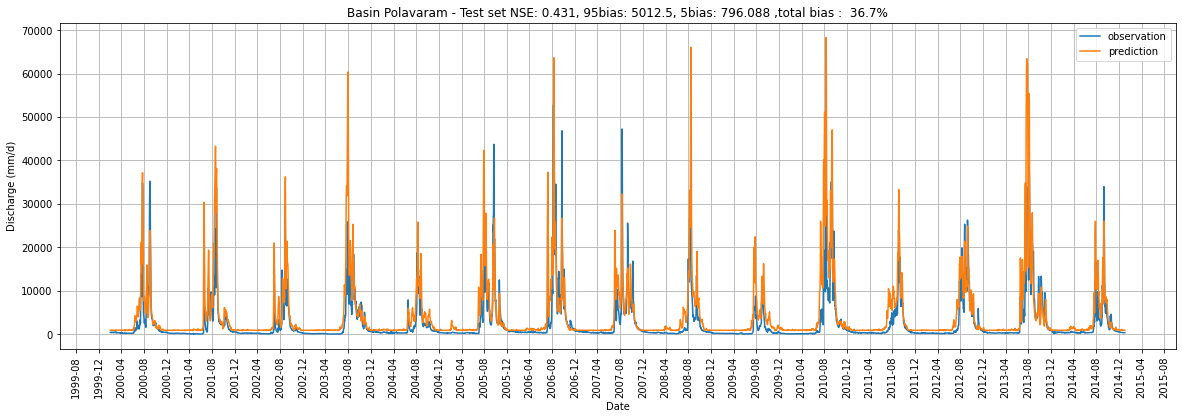

In [ ]:
# Evaluate on test set
# Validation data. We use the feature means/stds of the training period for normalization
start_date = (2000, 1, 1)
end_date = (2014, 12, 31)
Validation_basin = "Polavaram"
ds_val = IMDGodavari([Validation_basin], seq_length=sequence_length, period="eval", dates=[start_date, end_date], lead=lead, idx= idx_features, means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)
path_to_ckpt = None   
if path_to_ckpt:
  # 'drive/MyDrive/Efrat/model_lstm/2021_07_24-21-23-40/epoch_6_nse_0.825.ckpt'
  model = torch.load(path_to_ckpt)
obs, preds = eval_model(model, val_loader)
preds = ds_val.local_rescale(preds.cpu().numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)
pb95, pb5, total_b =  calc_bias(obs, preds)
# Plot results
start_date_tpl = ds_val.dates[0]
start_date = pd.to_datetime(datetime.datetime(start_date_tpl[0], start_date_tpl[1], start_date_tpl[2], 0, 0)) + pd.DateOffset(days=ds_val.seq_length + ds_val.lead)
end_date_tpl = ds_val.dates[1]
temp = pd.to_datetime(datetime.datetime(end_date_tpl[0], end_date_tpl[1], end_date_tpl[2], 0, 0))
end_date = temp + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(date_range, obs, label="observation")
ax.plot(date_range, preds, label="prediction")
ax.legend()
ax.set_title(f"Basin {Validation_basin} - Test set NSE: {nse:.3f}, 95bias: {pb95:.1f}, 5bias: {pb5:.3f} ,total bias : {total_b: .1f}%")
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.set_xlabel("Date")
ax.grid('on')
_ = ax.set_ylabel("Discharge (mm/d)")

In [ ]:
# Install package
!pip install captum
from captum.attr import IntegratedGradients

     |████████████████████████████████| 1.4 MB 8.3 MB/s 


In [ ]:
# Calculate Integrsted Gradients
start_date = (2005, 5, 1) 
end_date = (2005, 12, 1)
new_date_range, idx =  get_date_range_and_idx(start_date, end_date, date_range)
# set model to eval mode (important for dropout)
model.eval()
model.cpu()
ig =  IntegratedGradients(model, multiply_by_inputs=True)
input = Variable(ds_val.x[idx, : , : ])
basline = torch.zeros(input.shape)
att = ig.attribute(input, basline).numpy().mean(axis=0)
_ = model.cuda()

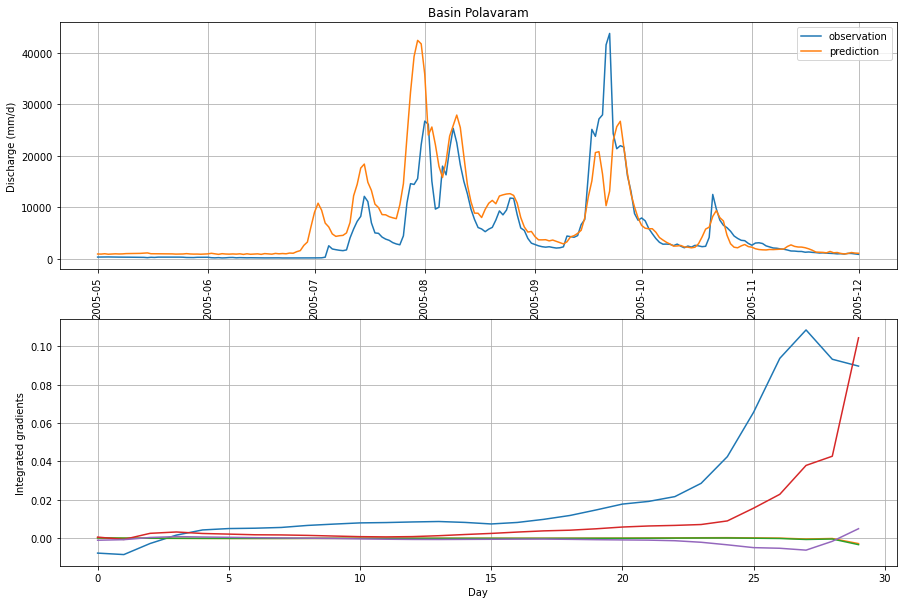

In [ ]:
# plot 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
ax1.plot(new_date_range, obs[idx], label="observation")
ax1.plot(new_date_range, preds[idx], label="prediction")
ax1.legend()
ax1.set_title(f"Basin {Validation_basin}")
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xlabel("Date")
ax1.grid('on')
_ = ax1.set_ylabel("Discharge (mm/d)")

ax2.plot(att)
ax2.set_xlabel("Day")
ax2.set_ylabel("Integrated gradients")
ax2.grid('on')
ax2.legend(['Mean Precipitation', 'Aridity', 'Area', 'Mean elevation'])